In [19]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from hyperopt import hp, tpe, Trials, fmin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import os
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

display(train.head(1))
display(test.head(1))
display(train.isnull().sum())
display(test.isnull().sum())

# 前処理を行う前に、いったんtrain,testを集約
df = train.append(test)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [20]:
# お金は平均値よりも中央値
df['Fare'].fillna(df['Fare'].dropna().median(), inplace=True)

df['Embarked'] = df['Embarked'].fillna(df.Embarked.mode().iloc[0])

df['Cabin'].fillna(str(0), inplace=True)

# Nameの前処理
df['Surname'] = df.Name.str.extract('([A-Za-z]+)\,' ,expand=False)
df['Title'] = df.Name.str.extract('([A-Za-z]+)\.' ,expand=False)
# 敬称については、意味を確認したうえで5個のクラスに整理
df['Title'].replace(['Lady','Countess','Capt', 'Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare',inplace=True)
df['Title'].replace('Mlle','Miss',inplace=True)
df['Title'].replace('Ms','Miss',inplace=True)
df['Title'].replace('Mme','Mrs',inplace=True)

# Cabinの前処理。これは頭文字だけを使いました。
# Cabinの頭文字（A〜F）が部屋の位置を表しているそうです。
# しかし実際には存在しない頭文字があるため、０で置換。
df['Cabin_Left'] = df['Cabin'].apply(lambda x: str(x)[0]) 
df['Cabin_Left'] = np.where((df['Cabin_Left']).isin([ 'F', 'E', 'D', 'C', 'B', 'A']),df['Cabin_Left'], np.where((df['Cabin_Left']).isin(['W', '4', '7', '6', 'L', '5', '8']), '0','0'))

# Ticketの前処理。これも頭文字だけを使いました。
df['Ticket_Lett'] = df['Ticket'].apply(lambda x: str(x)[0])



In [21]:
# 次に特徴量エンジニアリング
# Count　encoding、LabelCount　encoding、Label encoding、One-hot encodingを実施します。

# Surnameから実施
# Count encoding
count = df.Surname.value_counts()
df['Surname_Count'] = df.Surname.value_counts() 
df['Surname_Count'] = df['Surname'].map(count) 
# LabelCount encoding
count_rank = df.groupby('Surname')['Survived'].count().rank(ascending=False)
df['Surname_CountRank'] = df['Surname'].map(count_rank)

# 次にCabin。
# Label encoding
df['Cabin_Left']=df['Cabin_Left'].replace('A',1).replace('B',2).replace('C',3).replace('D',4).replace('E',5).replace('F',6)
# Count encoding
count = df.Cabin_Left.value_counts()
df['Cabin_Count'] = df['Cabin_Left'].map(count)
count = df.Cabin.value_counts()
df['Cabin_Count'] = df['Cabin'].map(count)
# LabelCount encoding
count_rank = df.groupby('Cabin_Left')['Survived'].count().rank(ascending=False)
df['Cabin_CountRank'] = df['Cabin_Left'].map(count_rank)
#　Cabinについては部屋番号末尾が偶数か奇数かで生存率が変わるということを知ったため、フラグ化
df['Cabin_Right'] = df['Cabin'].apply(lambda x: str(x)[-1])
df['Cabin_end'] = 'unknown'
df.Cabin_end[(df['Cabin_Right'] == '1')|(df['Cabin_Right'] == '3')|(df['Cabin_Right'] == '5')|(df['Cabin_Right'] == '7')|(df['Cabin_Right'] == '9')] = 'Odd'
df.Cabin_end[(df['Cabin_Right'] == '0')|(df['Cabin_Right'] == '2')|(df['Cabin_Right'] == '4')|(df['Cabin_Right'] == '6')|(df['Cabin_Right'] == '8')] = 'Even'
df.Cabin_end[df['Cabin'] == '0'] = 'Nan'
del df['Cabin_Right']


100%|██████████| 300/300 [01:29<00:00,  3.37it/s, best loss: 0.40766036868622374]
the AUC is : 0.8902


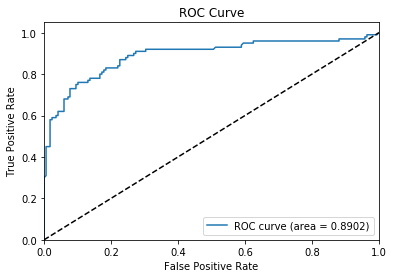

In [22]:
# 次にTicket。
# Count encoding
count = df.Ticket_Lett.value_counts()
df['TicketL_Count'] = df['Ticket_Lett'].map(count)
count = df.Ticket.value_counts()
df['Ticket_Count'] = df['Ticket'].map(count)
#LabelCount encoding
count_rank = df.groupby('Ticket_Lett')['Survived'].count().rank(ascending=False)
df['TicketL_CountRank'] = df['Ticket_Lett'].map(count_rank)
# 新たな特徴量としてTicketの長さも作成
df['Ticket_Len'] = df['Ticket'].apply(lambda x: len(x)) 

# 最後にFare
# LabelCount encoding
count_rank = df.groupby('Fare')['Survived'].count().rank(ascending=False)
df['Fare_CountRank'] = df['Fare'].map(count_rank)

# 家族数を新たな特徴量として作成
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# 家族がいない場合には、IsAloneフラグを作成
df['IsAlone'] = 0
df.loc[df['FamilySize'] == 1, 'IsAlone'] = 1

#Fareを10分割した特徴量を作成
df.loc[ df['Fare'] <= 51, 'Fare_band'] = 0
df.loc[(df['Fare'] > 51) & (df['Fare'] <= 102), 'Fare_band'] = 1
df.loc[(df['Fare'] > 102) & (df['Fare'] <= 153), 'Fare_band']   = 2
df.loc[(df['Fare'] > 153) & (df['Fare'] <= 204), 'Fare_band']   = 3
df.loc[(df['Fare'] > 204) & (df['Fare'] <= 256), 'Fare_band']   = 4
df.loc[(df['Fare'] > 256) & (df['Fare'] <= 307), 'Fare_band']   = 5
df.loc[(df['Fare'] > 307) & (df['Fare'] <= 358), 'Fare_band']   = 6
df.loc[(df['Fare'] > 358) & (df['Fare'] <= 409), 'Fare_band']   = 7
df.loc[(df['Fare'] > 409) & (df['Fare'] <= 461), 'Fare_band']   = 8
df.loc[ df['Fare'] > 461, 'Fare_band'] = 9
df['Fare_band'] = df['Fare_band'].astype(int)

# 性別について、Label encoding
df['Sex'] = df['Sex'].map({'female':1, 'male':0}).astype(int)

# カテゴリ変数をOne-hot encoding
df = df.drop(['PassengerId','Parch', 'SibSp','Name', 'Ticket','Cabin','Surname','Ticket_Lett'], axis=1)
df = pd.get_dummies(df)

df_Age = df.copy()
df_Age.Survived = df_Age.Survived.fillna(99)

Train = df_Age.dropna(subset=['Age'])
dev_y = Train['Age']
dev_x = Train.drop(['Age'], axis=1)

Test = df_Age[df_Age['Age'].isnull()]
Test = Test.drop(['Age'], axis=1)

model = RandomForestRegressor(random_state=1)
model.fit(dev_x,np.array(dev_y))
Test['Age'] = model.predict(Test)

Age = pd.concat([Train['Age'], Test['Age']])
df['Age'] = np.array(Age)

# Ageについても１０分割した特徴量を作成しています。
df.loc[ df['Age'] <= 8, 'Age_band'] = 0
df.loc[(df['Age'] > 8) & (df['Age'] <= 16), 'Age_band'] = 1
df.loc[(df['Age'] > 16) & (df['Age'] <= 24), 'Age_band'] = 2
df.loc[(df['Age'] > 24) & (df['Age'] <= 32), 'Age_band'] = 3
df.loc[(df['Age'] > 32) & (df['Age'] <= 40), 'Age_band'] = 4
df.loc[(df['Age'] > 40) & (df['Age'] <= 48), 'Age_band'] = 5
df.loc[(df['Age'] > 48) & (df['Age'] <= 56), 'Age_band'] = 6
df.loc[(df['Age'] > 56) & (df['Age'] <= 64), 'Age_band'] = 7
df.loc[(df['Age'] > 64) & (df['Age'] <= 72), 'Age_band'] = 8
df.loc[(df['Age'] > 72) & (df['Age'] <= 80), 'Age_band'] = 9

# データの処理が終わったので、モデリングを進めていきます。
# データの分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()]
ytrain = train['Survived']
Xtrain = train.drop('Survived',axis=1)

dev_X,val_X,dev_y,val_y = train_test_split(Xtrain,ytrain,test_size=0.3,random_state=0,shuffle=True)

# hyperoptによるパラメータチューニング
def objective(params):
    classifier = XGBClassifier(**params, random_state=0,n_jobs=-1)
    loss = cross_val_score(X=dev_X,estimator=classifier,n_jobs=-1,y=dev_y,scoring='neg_log_loss',cv=3).mean()
    return -1*loss

hyperopt_parameters = {
    'max_depth': hp.choice('max_depth', range(3, 8)),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'reg_alpha' :  hp.uniform('reg_alpha', 0.03, 1.0),
    'reg_lambda' :  hp.uniform('reg_lambda', 0.03, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0, 1, 0.05),}

max_evals = 300
trials = Trials()

# rstateの設定をしないと再現性が担保されないので、注意です。
best = fmin(objective,hyperopt_parameters,algo=tpe.suggest,max_evals=max_evals,trials=trials,verbose=-1,rstate=np.random.RandomState(0))

# ROCによるパフォーマンス確認用の関数
def Performance(Model,Y,X):
    # Perforamnce of the model
    fpr, tpr, _ = roc_curve(Y, Model.predict_proba(X)[:,1])
    AUC  = auc(fpr, tpr)
    print ('the AUC is : %0.4f' %  AUC)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % AUC)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
# モデルのパフォーマンス確認
xgbm = XGBClassifier(**best, random_state=0,n_jobs=-1)
xgbm.fit(dev_X,dev_y)
Performance(Model=xgbm,Y=val_y,X=val_X)

# 結果出力
index = pd.read_csv('test.csv')
submit = pd.DataFrame()
submit['PassengerId'] = index['PassengerId']
predict = xgbm.predict(test.drop('Survived',axis=1)).astype(int)
submit['Survived'] = predict
submit.to_csv('result.csv', index=False)